🚀 INICIANDO PIPELINE QUANT: BTC-USD [1h]
📊 Objetivo: Backtest Histórico (2y) + Otimização + ETL SQL
1️⃣ [EXTRACT] Baixando dados históricos...


C:\Users\Matheus\AppData\Local\Temp\ipykernel_9356\472406806.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ATIVO_TICKER, period=PERIODO_DADOS, interval=INTERVALO, progress=False)


   ✅ Dataset carregado: 17513 candles (2023-12-15 a 2025-12-15)
2️⃣ [TRANSFORM] Calculando indicadores técnicos...

3️⃣ [DATA SCIENCE] Iniciando Grid Search (Otimização)...
   -> Testando 9 combinações de hiperparâmetros...
   🏆 MELHOR CONFIGURAÇÃO: Stop 1.0% | Alvo 4.0%
   💰 Lucro Projetado: $600.00

🚀 Executando Backtest Final com parâmetros vencedores...
   📊 Resultado Final: $600.00 | Win Rate: 24.9% | Trades: 245

4️⃣ [LOAD] Salvando resultados no SQLite...
   ✅ Dados persistidos em 'track_record_quant.db' (Tabela: trades_btc_vwap)
   ℹ️  Dica: Use um software como 'DB Browser for SQLite' para auditar os dados.

5️⃣ [VISUALIZATION] Gerando gráfico interativo Plotly...


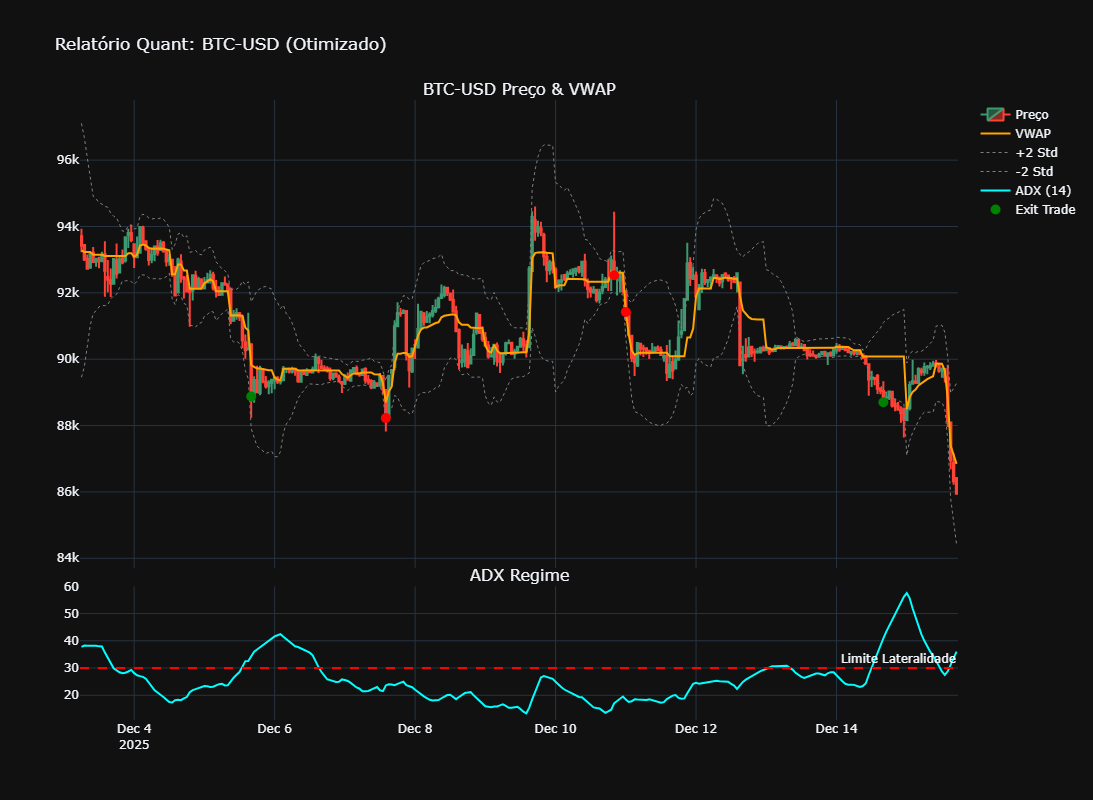

   ✅ Gráfico gerado.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sqlite3
import sys
import itertools

# --- CONFIGURAÇÕES DE ENGENHARIA (PROJETO JUNIOR QUANT) ---
ATIVO_TICKER = "BTC-USD"  # Cripto tem 24h, ideal para preencher dataset
PERIODO_DADOS = "2y"      # 2 Anos de histórico
INTERVALO = "1h"          # 1 Hora (Permite histórico longo no Yahoo)

# Banco de Dados (ETL)
DB_NOME = "track_record_quant.db"
TABELA_TRADES = "trades_btc_vwap"

# Configurações Iniciais da Simulação
CAPITAL_INICIAL = 10000.00  # USD
LOTE_FIXO_USD = 1000.00     # Entra com $1000 por trade (Gestão Fixa)

# Parâmetros Técnicos Fixos
DESVIO_PADRAO = 2.0
LIMITE_ADX = 30 # Aumentei um pouco pois 1H é mais ruidoso que 1M
FILTRAR_VOLUME = False # Crypto no Yahoo as vezes tem volume estranho, melhor deixar False

print(f"🚀 INICIANDO PIPELINE QUANT: {ATIVO_TICKER} [{INTERVALO}]")
print(f"📊 Objetivo: Backtest Histórico ({PERIODO_DADOS}) + Otimização + ETL SQL")

# --- 1. CAMADA ETL: EXTRAÇÃO E TRANSFORMAÇÃO ---
def carregar_dados_bigdata():
    """Baixa dados de longo prazo (Swimg Trade)."""
    print("1️⃣ [EXTRACT] Baixando dados históricos...")
    try:
        df = yf.download(ATIVO_TICKER, period=PERIODO_DADOS, interval=INTERVALO, progress=False)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)
        
        # Tratamento de Nulos
        df = df.dropna()
        
        # Correção de Volume (se vier zerado/falso)
        if 'Volume' in df.columns and (df['Volume'] == 0).all():
            df['Volume'] = 1
            
        print(f"   ✅ Dataset carregado: {len(df)} candles ({df.index[0].date()} a {df.index[-1].date()})")
        return df
    except Exception as e:
        print(f"   ❌ Erro no download: {e}")
        sys.exit()

def calcular_indicadores(df):
    """Engenharia de Features (Indicadores)."""
    print("2️⃣ [TRANSFORM] Calculando indicadores técnicos...")
    
    # Proteção
    df['Volume'] = df['Volume'].replace(0, 1)
    
    # A. VWAP (Reinicia a cada dia, mesmo em H1)
    df['Volume_Price'] = df['Close'] * df['Volume']
    df['Date_Group'] = df.index.date
    df['Cum_Vol'] = df.groupby('Date_Group')['Volume'].cumsum()
    df['Cum_Vol_Price'] = df.groupby('Date_Group')['Volume_Price'].cumsum()
    df['VWAP'] = df['Cum_Vol_Price'] / df['Cum_Vol']
    
    # B. Bandas
    df['Std_Dev'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['VWAP'] + (DESVIO_PADRAO * df['Std_Dev'])
    df['Lower_Band'] = df['VWAP'] - (DESVIO_PADRAO * df['Std_Dev'])
    
    # C. ADX (Wilder)
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    
    def rma(x, n): return x.ewm(alpha=1/n, adjust=False).mean()
    
    df['TR_14'] = rma(df['TR'], 14)
    df['UpMove'] = df['High'] - df['High'].shift(1)
    df['DownMove'] = df['Low'].shift(1) - df['Low']
    df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > 0), df['UpMove'], 0)
    df['MinusDM'] = np.where((df['DownMove'] > df['UpMove']) & (df['DownMove'] > 0), df['DownMove'], 0)
    
    df['PlusDI_14'] = 100 * rma(df['PlusDM'], 14) / df['TR_14']
    df['MinusDI_14'] = 100 * rma(df['MinusDM'], 14) / df['TR_14']
    df['DX'] = 100 * abs(df['PlusDI_14'] - df['MinusDI_14']) / (df['PlusDI_14'] + df['MinusDI_14'])
    df['ADX_14'] = rma(df['DX'], 14)
    
    return df.dropna()

# --- 2. CORE DE TRADING (OTIMIZÁVEL) ---
def rodar_backtest(df, stop_pct, target_pct):
    """
    Roda o backtest com parâmetros variáveis (para Grid Search).
    stop_pct: % de Stop Loss (ex: 0.02 para 2%)
    target_pct: % de Alvo (ex: 0.04 para 4%)
    """
    trades = []
    capital = CAPITAL_INICIAL
    posicao = 0 # 0, 1 (Long), -1 (Short)
    preco_entrada = 0.0
    
    # Loop rápido com itertuples
    for row in df.itertuples():
        
        # --- REGRAS DE SAÍDA ---
        if posicao != 0:
            pnl = 0
            saiu = False
            tipo_saida = ""
            
            # Definir preços de saída baseados na %
            if posicao == 1:
                stop_price = preco_entrada * (1 - stop_pct)
                target_price = preco_entrada * (1 + target_pct)
                
                if row.Low <= stop_price:
                    saiu = True; tipo_saida = "STOP"; pnl = -stop_pct
                elif row.High >= target_price:
                    saiu = True; tipo_saida = "ALVO"; pnl = target_pct
                    
            elif posicao == -1:
                stop_price = preco_entrada * (1 + stop_pct)
                target_price = preco_entrada * (1 - target_pct)
                
                if row.High >= stop_price:
                    saiu = True; tipo_saida = "STOP"; pnl = -stop_pct
                elif row.Low <= target_price:
                    saiu = True; tipo_saida = "ALVO"; pnl = target_pct
            
            if saiu:
                resultado_usd = LOTE_FIXO_USD * pnl
                capital += resultado_usd
                trades.append({
                    'Data': row.Index,
                    'Tipo': tipo_saida,
                    'Lado': 'COMPRA' if posicao == 1 else 'VENDA',
                    'Retorno_Perc': pnl,
                    'Lucro_USD': resultado_usd,
                    'Capital_Acumulado': capital
                })
                posicao = 0
                continue

        # --- REGRAS DE ENTRADA ---
        # Filtro de Lateralidade (Mean Reversion)
        regime_lateral = (row.ADX_14 < LIMITE_ADX)
        
        if regime_lateral and posicao == 0:
            # Compra: Preço abaixo da banda e candle de reversão (fechou positivo)
            if (row.Close < row.VWAP) and (row.Low <= row.Lower_Band) and (row.Close > row.Open):
                posicao = 1
                preco_entrada = row.Close
                
            # Venda: Preço acima da banda e candle de reversão (fechou negativo)
            elif (row.Close > row.VWAP) and (row.High >= row.Upper_Band) and (row.Close < row.Open):
                posicao = -1
                preco_entrada = row.Close

    return pd.DataFrame(trades)

# --- 3. ALGORITMO DE OTIMIZAÇÃO (GRID SEARCH) ---
def otimizar_parametros(df):
    print("\n3️⃣ [DATA SCIENCE] Iniciando Grid Search (Otimização)...")
    
    # Parâmetros para testar (Crypto precisa de stops maiores que Indice)
    lista_stops = [0.01, 0.02, 0.03] # 1%, 2%, 3%
    lista_alvos = [0.02, 0.04, 0.06] # 2%, 4%, 6%
    
    melhor_resultado = -999999
    melhor_config = (0, 0)
    resultados_grid = []

    # Produto Cartesiano (todas as combinações)
    combinacoes = list(itertools.product(lista_stops, lista_alvos))
    print(f"   -> Testando {len(combinacoes)} combinações de hiperparâmetros...")

    for stop, alvo in combinacoes:
        df_res = rodar_backtest(df, stop_pct=stop, target_pct=alvo)
        
        if not df_res.empty:
            lucro_total = df_res['Lucro_USD'].sum()
            qtd_trades = len(df_res)
            
            # Critério de Seleção: Lucro Máximo (desde que tenha min 10 trades)
            if lucro_total > melhor_resultado and qtd_trades > 10:
                melhor_resultado = lucro_total
                melhor_config = (stop, alvo)
            
            # Print de progresso curto
            # print(f"      Stop: {stop*100}% | Alvo: {alvo*100}% -> Lucro: ${lucro_total:.2f} ({qtd_trades} trades)")

    print(f"   🏆 MELHOR CONFIGURAÇÃO: Stop {melhor_config[0]*100}% | Alvo {melhor_config[1]*100}%")
    print(f"   💰 Lucro Projetado: ${melhor_resultado:.2f}")
    
    return melhor_config

# --- 4. CARGA (SQL) E VISUALIZAÇÃO ---
def salvar_etl_sql(df_trades):
    print("\n4️⃣ [LOAD] Salvando resultados no SQLite...")
    if df_trades.empty:
        print("   ⚠️ Sem trades para salvar.")
        return

    try:
        conn = sqlite3.connect(DB_NOME)
        # Convertendo timestamp para string para compatibilidade SQL
        df_salvar = df_trades.copy()
        df_salvar['Data'] = df_salvar['Data'].astype(str)
        
        df_salvar.to_sql(TABELA_TRADES, conn, if_exists='replace', index=False)
        conn.close()
        print(f"   ✅ Dados persistidos em '{DB_NOME}' (Tabela: {TABELA_TRADES})")
        print("   ℹ️  Dica: Use um software como 'DB Browser for SQLite' para auditar os dados.")
    except Exception as e:
        print(f"   ❌ Erro SQL: {e}")

def plotar_grafico_interativo(df_dados, df_trades):
    print("\n5️⃣ [VISUALIZATION] Gerando gráfico interativo Plotly...")
    
    # Pegar apenas os últimos 300 candles para o gráfico não ficar pesado
    df_zoom = df_dados.tail(300) 
    
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        vertical_spacing=0.03, subplot_titles=(f'{ATIVO_TICKER} Preço & VWAP', 'ADX Regime'),
                        row_width=[0.2, 0.7])

    # Candlestick
    fig.add_trace(go.Candlestick(x=df_zoom.index,
                                 open=df_zoom['Open'], high=df_zoom['High'],
                                 low=df_zoom['Low'], close=df_zoom['Close'],
                                 name='Preço'), row=1, col=1)

    # VWAP e Bandas
    fig.add_trace(go.Scatter(x=df_zoom.index, y=df_zoom['VWAP'], line=dict(color='orange', width=2), name='VWAP'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_zoom.index, y=df_zoom['Upper_Band'], line=dict(color='gray', width=1, dash='dot'), name='+2 Std'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_zoom.index, y=df_zoom['Lower_Band'], line=dict(color='gray', width=1, dash='dot'), name='-2 Std'), row=1, col=1)

    # ADX
    fig.add_trace(go.Scatter(x=df_zoom.index, y=df_zoom['ADX_14'], line=dict(color='cyan', width=2), name='ADX (14)'), row=2, col=1)
    fig.add_hline(y=LIMITE_ADX, line_dash="dash", line_color="red", annotation_text="Limite Lateralidade", row=2, col=1)

    # Adicionar Marcadores de Trade (se houver no período do zoom)
    mask_trades = df_trades['Data'].isin(df_zoom.index)
    trades_zoom = df_trades[mask_trades]
    
    if not trades_zoom.empty:
        # Filtra compras e vendas
        # Nota: Como o DF de trades tem data de saida, marcamos a saida. Para entrada precisariamos guardar data entrada.
        # Simplificacao: Marcamos o momento da saída e o resultado
        fig.add_trace(go.Scatter(
            x=trades_zoom['Data'], 
            y=df_zoom.loc[trades_zoom['Data']]['Close'], # Pega preço aproximado do candle de saída
            mode='markers',
            marker=dict(size=10, color=np.where(trades_zoom['Lucro_USD'] > 0, 'green', 'red')),
            name='Exit Trade'
        ), row=1, col=1)

    fig.update_layout(title=f"Relatório Quant: {ATIVO_TICKER} (Otimizado)", 
                      template="plotly_dark", xaxis_rangeslider_visible=False, height=800)
    
    fig.show()
    print("   ✅ Gráfico gerado.")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Pipeline de Dados
    df_raw = carregar_dados_bigdata()
    df_ind = calcular_indicadores(df_raw)
    
    # 2. Otimização (Machine Learning Lite)
    melhor_stop, melhor_alvo = otimizar_parametros(df_ind)
    
    # 3. Execução Final (Com os melhores parametros)
    print("\n🚀 Executando Backtest Final com parâmetros vencedores...")
    df_resultado = rodar_backtest(df_ind, stop_pct=melhor_stop, target_pct=melhor_alvo)
    
    if not df_resultado.empty:
        # Métricas Finais
        total_lucro = df_resultado['Lucro_USD'].sum()
        win_rate = len(df_resultado[df_resultado['Lucro_USD'] > 0]) / len(df_resultado) * 100
        print(f"   📊 Resultado Final: ${total_lucro:.2f} | Win Rate: {win_rate:.1f}% | Trades: {len(df_resultado)}")
        
        # 4. ETL SQL
        salvar_etl_sql(df_resultado)
        
        # 5. Visualização
        plotar_grafico_interativo(df_ind, df_resultado)
    else:
        print("   ❌ Nenhum trade encontrado mesmo após otimização.")

In [4]:
import pandas as pd
import sqlite3

# 1. Conecta no arquivo do banco
conn = sqlite3.connect('track_record_quant.db')

# 2. Escreve a Query (A pergunta pro banco)
query = "SELECT * FROM trades_btc_vwap"

# 3. Puxa para um DataFrame e mostra
df_sql = pd.read_sql_query(query, conn)
conn.close()

# Mostra as primeiras 100 linhas
display(df_sql.head(100))

# Mostra o lucro total somando pelo SQL (Prova real)
print(f"Lucro Total no Banco: {df_sql['Lucro_USD'].sum()}")

,Data,Tipo,Lado,Retorno_Perc,Lucro_USD,Capital_Acumulado
0,2023-12-18 21:00:00+00:00,STOP,VENDA,-0.01,-10.0,9990.0
1,2023-12-19 01:00:00+00:00,STOP,VENDA,-0.01,-10.0,9980.0
2,2023-12-22 06:00:00+00:00,STOP,VENDA,-0.01,-10.0,9970.0
3,2023-12-24 22:00:00+00:00,STOP,COMPRA,-0.01,-10.0,9960.0
4,2023-12-28 16:00:00+00:00,STOP,COMPRA,-0.01,-10.0,9950.0
...,...,...,...,...,...,...
95,2024-08-27 15:00:00+00:00,ALVO,VENDA,0.04,40.0,9990.0
96,2024-09-01 02:00:00+00:00,STOP,COMPRA,-0.01,-10.0,9980.0
97,2024-09-03 02:00:00+00:00,STOP,VENDA,-0.01,-10.0,9970.0
98,2024-09-08 15:00:00+00:00,STOP,COMPRA,-0.01,-10.0,9960.0


Lucro Total no Banco: 600.0
